<a href="https://colab.research.google.com/github/JoDeMiro/DeepLearningIntroduction/blob/main/Train_and_Debug_YOLOv5_Models_with_Weights_%26_Biases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://user-images.githubusercontent.com/26833433/82952157-51b7db00-9f5d-11ea-8f4b-dda1ffecf992.jpg">


<!--- @wandbcode{yolov5-train} -->

<img src="https://i.imgur.com/gb6B4ig.png" width="400" alt="Weights & Biases" />


# Train and Debug YOLOv5 Models with Weights & Biases

In this colab,
we'll demonstrate how to use the W&B integration with
version 5 of the "You Only Look Once"
(aka [YOLOv5](https://github.com/ultralytics/yolov5))
real-time object detection framework
to track model metrics,
inspect model outputs,
and restart interrupted runs.

### Follow along with a [video tutorial →](https://wandb.me/yolo-video)

# Setup

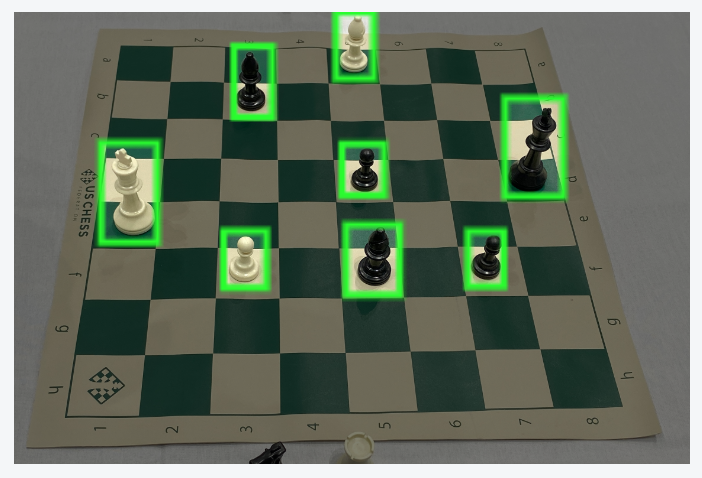

We begin by downloading the
[YOLOv5 GitHub repo](https://github.com/ultralytics/yolov5)
and a
[dataset of chessboard images with labeled bounding boxes around the pieces](https://public.roboflow.com/object-detection/chess-full).
Below, we'll use this dataset to train a model to detect chess pieces in images.

We also install all the requirements for YOLOv5 and `wandb`.

In [1]:
%%capture
!git clone https://github.com/ultralytics/yolov5.git
!curl -L "https://public.roboflow.com/ds/1BpjFZe9ST?key=KXD7eDvwTa" > roboflow.zip; unzip -o roboflow.zip; rm roboflow.zip
%cd /content/yolov5
!pip install -r requirements.txt
!pip install wandb

# Detect

YOLOv5 provides highly-accurate, fast models that are pretrained on the
[Common Objects in COntext (COCO) dataset](https://cocodataset.org/#home).

If your object detection application involves only
[classes from the COCO dataset](https://gist.github.com/AruniRC/7b3dadd004da04c80198557db5da4bda),
like "Stop Sign" and "Pizza",
then these pretrained models may be all you need!

The cell below runs a pretrained model on an example image
using `detect.py` from the YOLOv5 toolkit.

detect: weights=['yolov5s.pt'], source=data/images/bus.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-247-gc21da59 torch 1.10.0+cu111 CPU

100% 14.0M/14.0M [00:00<00:00, 16.8MB/s]

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
image 1/1 /content/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, Done. (0.397s)
Speed: 5.5ms pre-process, 397.4ms inference, 25.3ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


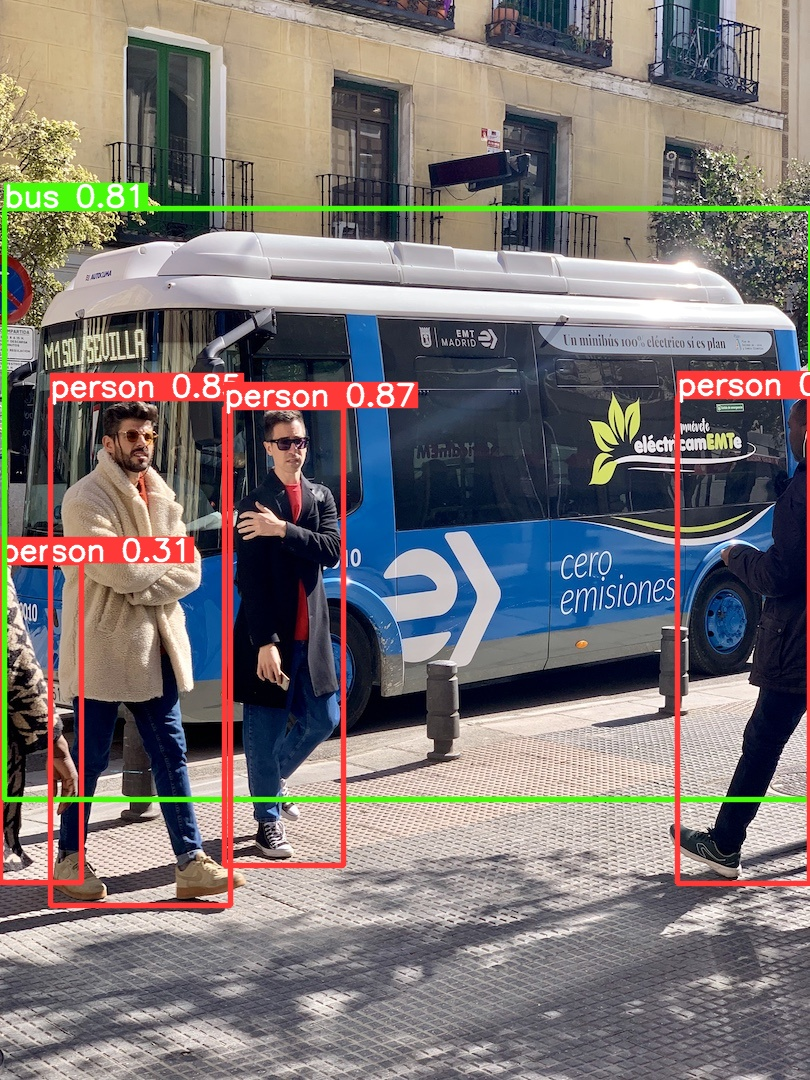

In [2]:
from IPython.display import Image

!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images/bus.jpg
Image(filename='runs/detect/exp/bus.jpg', width=600)

In [15]:
# !wget https://github.com/JoDeMiro/Data/raw/main/Images/woman1.png
!cp woman1.png /content/yolov5/data/images/

detect: weights=['yolov5s.pt'], source=woman1.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-247-gc21da59 torch 1.10.0+cu111 CPU

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
image 1/1 /content/yolov5/woman1.png: 448x640 1 person, 1 boat, Done. (0.308s)
Speed: 2.8ms pre-process, 307.8ms inference, 2.1ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp5


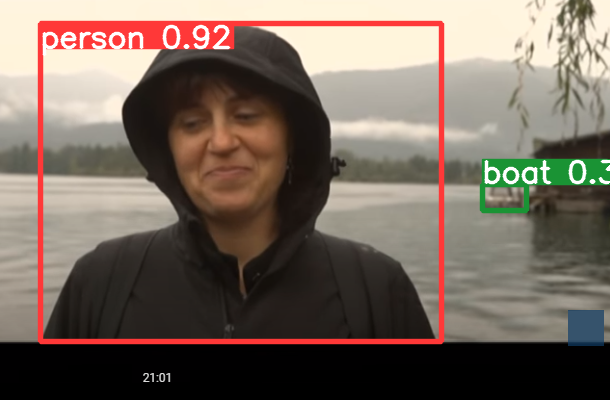

In [18]:
from IPython.display import Image

!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source woman1.png
Image(filename='runs/detect/exp2/woman1.png', width=600)

# Train


Chess pieces are not among the objects in COCO,
so our pretrained models don't know how to detect them
and we can't just use `detect.py` with one of those models.

Instead, we need to train the models to detect chess pieces,
using YOLOv5's `train.py`.
We don't have to start our models from scratch though!
We can [finetune](https://morioh.com/p/4cd5996c0e64)
the pretrained models on our chess piece dataset.
This substantially speeds up training.

Model training is a complex process,
so we'll want to track the inputs and outputs,
log information about model behavior during training,
and record system state and metrics.
Additionally, we might 

That's where [Weights & Biases](https://wandb.ai/site)
comes in:
the `wandb` library provides all the tools you need to thoroughly
and effectively log model training experiments.

YOLOv5 comes with `wandb` already integrated,
so all you need to do is configure the logging
with command line arguments.

* `--project` sets the W&B project to which we're logging
(akin to a GitHub repo).
* `--upload_dataset` tells `wandb`
to upload the dataset as [a dataset-visualization Table](https://docs.wandb.ai/guides/datasets-and-predictions).
At regular intervals set by `--bbox_interval`,
the model's outputs on the validation set will also be logged to W&B.
* `--save-period` sets the number of epochs to wait
in between logging the model checkpoints.
If not set, only the final trained model is logged.

Even without these arguments,
basic model metrics and some model outputs will still be saved to W&B.


> _Note_: to use this same training and logging setup on a different dataset,
just [create a `data.yaml` for that dataset](https://github.com/ultralytics/yolov5/issues/12)
and provide it to the `--data` argument.

In [19]:
!python train.py \
  --data ../data.yaml \
  --epochs 3 \
  --project yolo-wandb-demo \
  --upload_dataset \
  --bbox_interval 1 \
  --save-period 1

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 9833dbceaa4bd6b886be2f6e8cdae2faf689ee36
wandb: WARNING Invalid choice
wandb: Enter your choice: (30 second timeout) 2
wandb: You chose 'Use an existing W&B account'
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
train: weights=yolov5s.pt, cfg=, data=../data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=3, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolo-wandb-demo, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patienc

Here's where you can find the uploaded evaluation results in the W&B UI:


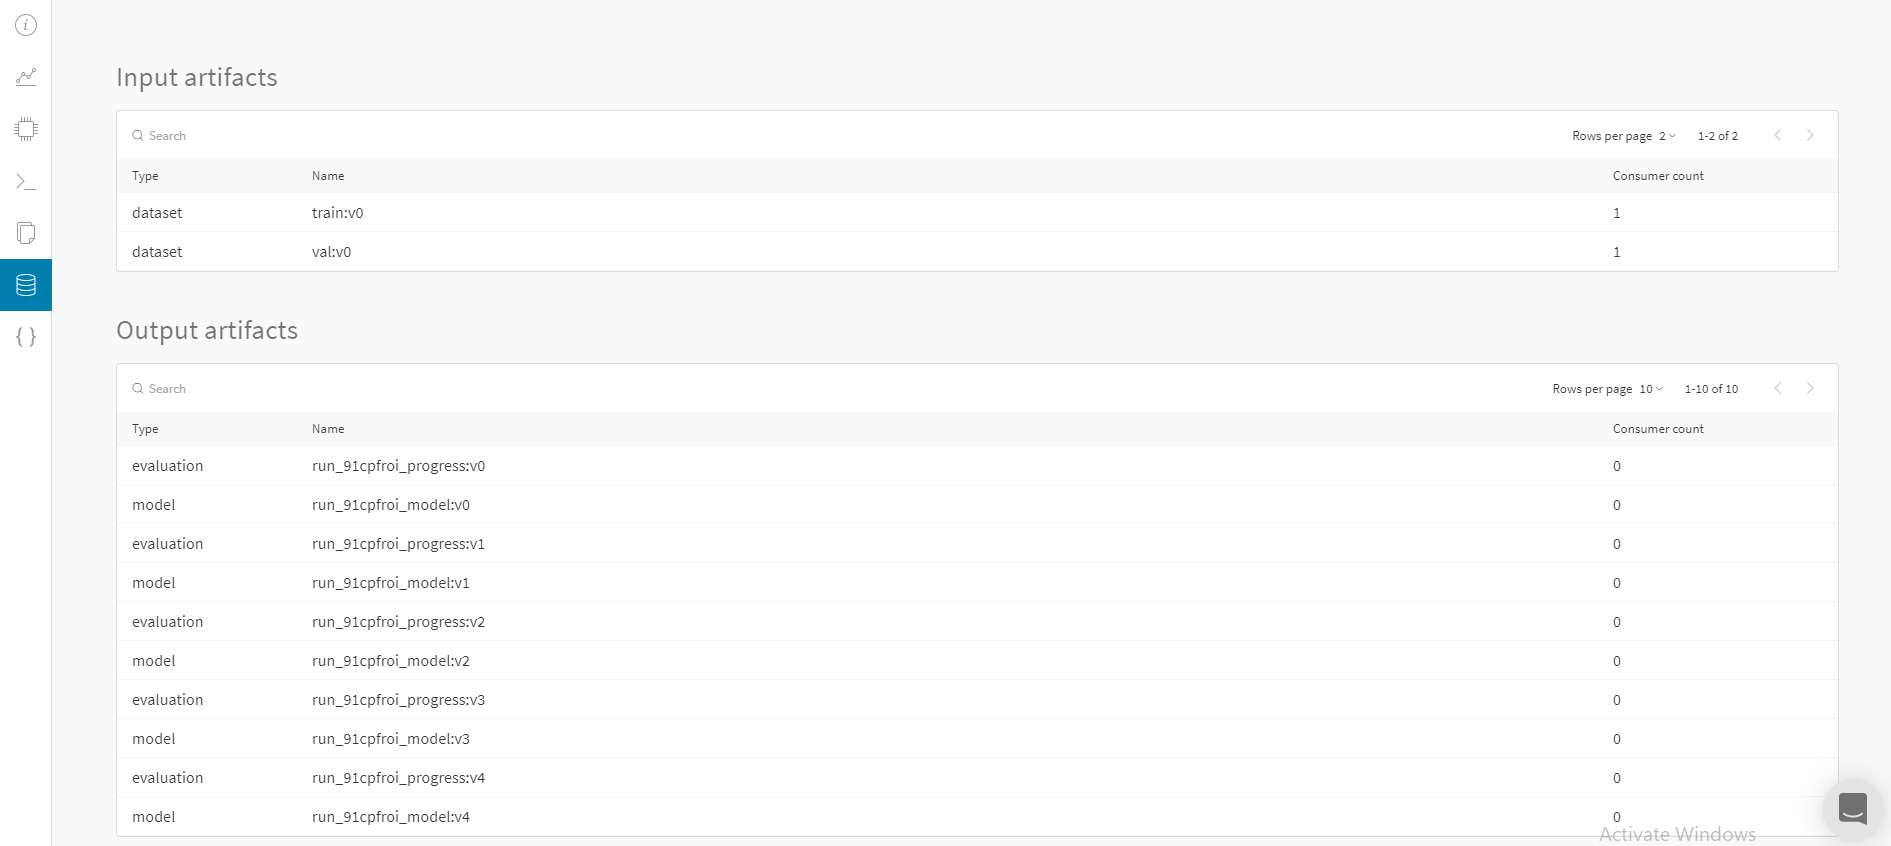

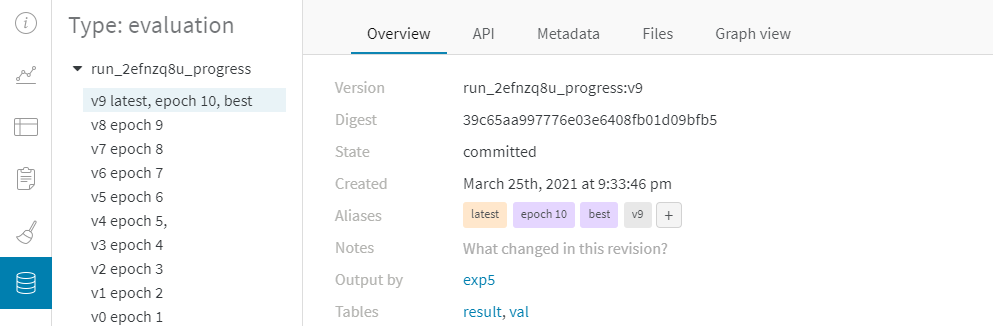


# Resume Crashed Runs

In addition to making it easier to debug our models,
the W&B integration can help rescue crash or interrupted runs.

Two steps above helped set us up for this:
1. By setting a `--save-period`, we regularly logged the model to W&B,
which means we can recreate our model and then resume the run on any
device with the dataset available.
2. By using `--upload_dataset`, we logged the data to W&B,
which means we can recreate the data as well and so
resume runs on any device, whether the dataset is present on disk or not

To resume a crashed or interrupted run:
* Go to that run's overview section on W&B dashboard
* Copy the run path
* Pass the run path as the `--resume` argument, plus the prefix
`wandb-artifact://`.
This prefix tells YOLO that the files are located on wandb, rather than locally.

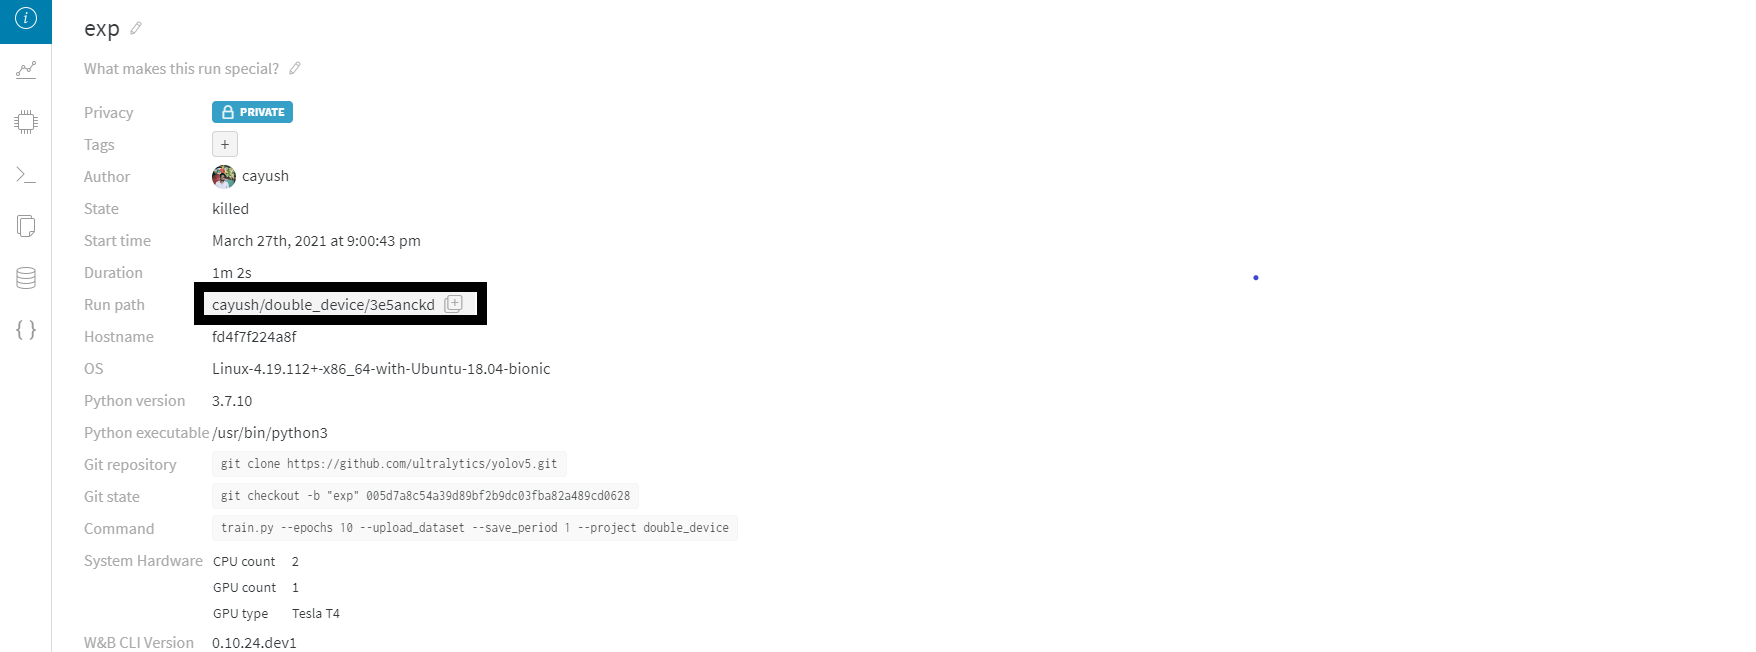


```python
crashed_run_path = "entity/project/run-id"  # your path here
!python train.py --resume wandb-artifact://{crashed_run_path}
```

# End Notes

### Distributed Data-Parallel Training

All YOLO+W&B features are
DDP-aware and compatible.
Train on as many GPUs as you can muster,
and we'll keep logging!

### Logging Large Datasets

For very large datasets,
the initial dataset upload triggered by `--log_dataset`
might be prohibitively expensive.

In that case,
check out the
[`log_dataset.py` script](https://github.com/ultralytics/yolov5/blob/master/utils/wandb_logging/log_dataset.py)
included in YOLOv5.

### `stripped` Models

At the end of training,
a "stripped" version of the model is saved
to W&B.
This version of the model file is much smaller,
but is missing
accumulated data required for resuming training.
It's intended for use in downstream inference.